In [13]:
import os,string,numpy

def removePunctuation(line):
    table = str.maketrans(dict.fromkeys(string.punctuation))
    return line.translate(table)

def ENwordValid(word):
    if(word.isalpha() and (word[0].islower() or word.istitle())):
        return True
    return False

def numberSpecialFree(word):
    if word == "–":
        return False
    return not any(word.isdigit() for char in word)

In [14]:
def preprocess_file(file_name, brown = False, dir = os.getcwd(),dictionary = {}, text_list = []):
            with open(dir + "/" + file_name,'r') as file:     
                for line in file:
                    for word in line.split():
                        word = removePunctuation(word.split("/")[0])
                        if(ENwordValid(word)):
                            word = word.lower()
                            text_list.append(word)
                            if(word in dictionary):
                                dictionary[word] = dictionary[word] + 1
                            else: dictionary[word] = 1
            d2 = dictionary.copy()
            l2 = text_list.copy()
            dictionary.clear()
            text_list.clear()
            return d2,l2

def preprocess_file_part(file_name, part=1, brown = False, dir = os.getcwd(),dictionary = {}, text_list = []):
            with open(dir + "/" + file_name,'r') as file:
                lines=file.readlines()
                for i in range(int(numpy.ceil(part*len(lines)))):
                    line = lines[i]
                    for word in line.split():
                        word = removePunctuation(word.split("/")[0])
                        if(ENwordValid(word)):
                            word = word.lower()
                            text_list.append(word)
                            if(word in dictionary):
                                dictionary[word] = dictionary[word] + 1
                            else: dictionary[word] = 1
            d2 = dictionary.copy()
            l2 = text_list.copy()
            dictionary.clear()
            text_list.clear()
            return d2,l2

def preprocess_folder(fdir,is_brown):
    fdic = {}
    flist = []
    for filename in os.listdir(fdir):
        if len(filename) < 5:                     #Change this depending on the folder structure
            fdic, flist = preprocess_file(filename,1,is_brown,fdir,fdic,flist)
    dic_final = sorted(fdic.items(), key=lambda x: x[1], reverse=True)
    return dic_final
            
                

In [15]:
#This function calculates the unigram probability distribution
def construct_unigram(dic):
    summation = 0
    dic_unigram = dic.copy()
    for key in dic_unigram:
        summation = summation + dic_unigram[key]
    for key in dic:
        dic_unigram[key] = dic_unigram[key]/summation
    return dic_unigram

#This function calculates the bigram probability distribution
def construct_bigram(lst):
    dic_bigram = {}
    dic_predecessor = {}
    for i in range(1,len(lst)):
        if(lst[i-1] in dic_predecessor):
            dic_predecessor[lst[i-1]] = dic_predecessor[lst[i-1]]  + 1
        else: dic_predecessor[lst[i-1]] = 1
        pair = (lst[i],lst[i-1])
        if(pair in dic_bigram):
            dic_bigram[pair] = dic_bigram[pair] + 1
        else: dic_bigram[pair] = 1
    for key in dic_bigram:
        dic_bigram[key] = dic_bigram[key]/dic_predecessor[key[1]]
    return dic_bigram

#This function calculates the unigram counts and sum
def construct_unigram_dic(dic):
    summation = 0
    dic_unigram = dic.copy()
    for key in dic_unigram:
        summation = summation + dic_unigram[key]
    return dic_unigram,summation
    
#This function calculates the pair counts and the predecessor (2nd word) counts
def construct_bigram_dics(lst):
    dic_intersection = {}
    dic_predecessor = {}
    for i in range(1,len(lst)):
        if(lst[i-1] in dic_predecessor):
            dic_predecessor[lst[i-1]] = dic_predecessor[lst[i-1]]  + 1
        else: dic_predecessor[lst[i-1]] = 1
        pair = (lst[i],lst[i-1])
        if(pair in dic_intersection):
            dic_intersection[pair] = dic_intersection[pair] + 1
        else: dic_intersection[pair] = 1
    return dic_intersection,dic_predecessor

def smooth_unigram(train,summation,test):
    for i in test:
        if i not in train:
            summation = summation + 1
            train[i] = 1
    for i in train:
        train[i] = train[i]/summation
            
def smooth_lidstone(pair,predecessor,dic_intersect,dic_predecessor):
    alpha = 0.03
    numerator = dic_intersect[pair] + alpha
    denominator = dic_predecessor[predecessor] + alpha*len(dic_predecessor)
    return numerator/denominator
    
def calc_unigram_perplexity(dic,tstdic):
    power_term = 0
    for k in dic:
        if k in tstdic:
            power_term = power_term + dic[k]*numpy.log(dic[k])
    return numpy.exp(-1*power_term)

def calc_bigram_perplexity(train,tst1,tst2):
    power_term = 0
    count_bigrams = 0
    for i in tst1:
        count_bigrams = count_bigrams + tst1[i]
    for i in tst1:
        f = tst1[i]/count_bigrams
        if i not in train:
            p = smooth_lidstone(i,i[1],tst1,tst2)
        else: p = train[i]
        power_term = power_term + f*numpy.log(p)
    return numpy.exp(-1*power_term)
        

In [39]:
tr_dic,tr_list = preprocess_file("English_train.txt")
tst_dic,tst_list = preprocess_file("English_test.txt")

train,summation = construct_unigram_dic(tr_dic)
smooth_unigram(train,summation,tst_dic)

print("Perplexity of Unigram is " + str(calc_unigram_perplexity(train,tst_dic)))

tr_bigram = construct_bigram(tr_list)
tst_intersect,tst_predecessor = construct_bigram_dics(tst_list)

print("Perplexity of Bigram is " + str(calc_bigram_perplexity(tr_bigram,tst_intersect,tst_predecessor)))

print ("Perplexity of Bigram is clearly lower because it predicts the next word based on a historical context which decreases its error rate")

print ("Smoothing is important because the absence of words (i.e having p = 0) will eliminate the whole product to 0")

print ("Smoothing adds relevant probabilities to abscent words and adjusts others accordingly to compute meaningful perplexity")






Perplexity of Unigram is 245.25567915178104
Perplexity of Bigram is 65.65707830853653
Perplexity of Bigram is clearly lower because it predicts the next word based on a historical context which decreases its error rate
Smoothing is important because the absence of words (i.e having p = 0) will eliminate the whole product to 0
Smoothing adds relevant probabilities to abscent words and adjusts others accordingly to compute meaningful perplexity


In [44]:
tst_intersect,tst_predecessor = construct_bigram_dics(tst_list)
x_values = []
y_values = []

dic,percent_ls = preprocess_file_part("English_train.txt",0.2)
tr_percent_bigram = construct_bigram(percent_ls)
x_values.append("20%")
pp = calc_bigram_perplexity(tr_percent_bigram,tst_intersect,tst_predecessor)
y_values.append(pp)
print("Perplexity at 20% is " + str(pp))

dic,percent_ls = preprocess_file_part("English_train.txt",0.4)
tr_percent_bigram = construct_bigram(percent_ls)
x_values.append("40%")
pp = calc_bigram_perplexity(tr_percent_bigram,tst_intersect,tst_predecessor)
y_values.append(pp)
print("Perplexity at 40% is " + str(pp))


dic,percent_ls = preprocess_file_part("English_train.txt",0.6)
tr_percent_bigram = construct_bigram(percent_ls)
x_values.append("60%")
pp = calc_bigram_perplexity(tr_percent_bigram,tst_intersect,tst_predecessor)
y_values.append(pp)
print("Perplexity at 60% is " + str(pp))

dic,percent_ls = preprocess_file_part("English_train.txt",0.8)
tr_percent_bigram = construct_bigram(percent_ls)
x_values.append("80%")
pp = calc_bigram_perplexity(tr_percent_bigram,tst_intersect,tst_predecessor)
y_values.append(pp)
print("Perplexity at 80% is " + str(pp))


dic,percent_ls = preprocess_file_part("English_train.txt",1)
tr_percent_bigram = construct_bigram(percent_ls)
x_values.append("100%")
pp = calc_bigram_perplexity(tr_percent_bigram,tst_intersect,tst_predecessor)
y_values.append(pp)
print("Perplexity at 100% is " + str(pp))



Perplexity at 20% is 65.2550435623207
Perplexity at 40% is 64.41131629834419
Perplexity at 60% is 64.34582210159287
Perplexity at 80% is 64.95879474195284
Perplexity at 100% is 65.65707830853653


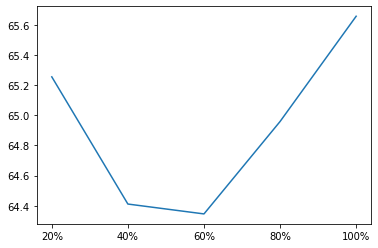

by increasing the training corpus the perplexity decreases till a point where further increase increases it again
This means that these increases added information that adds more noise wrt to the scope of testing corpus


In [47]:
import matplotlib.pyplot as plt
plt.plot(x_values,y_values,label = "perplexity")
plt.show()

print("by increasing the training corpus the perplexity decreases till a point where further increase increases it again")
print("This means that these increases added information that adds more noise wrt to the scope of testing corpus")